# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json

from time import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

## Data Exploration

to find out the problem , so first we have to explore the datasets to found which data includes the missing value , then visualize the data distribution , for better understand on how the datasets look 

In [2]:
# view the portfolio dataset
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
#the shape of dateset
portfolio.shape

(10, 6)

In [4]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [5]:
portfolio.isnull().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [6]:
# number of unique offer in dataset
portfolio.id.nunique()

10

In [7]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [8]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


#### after veiwing the first row of the dataset , it's showing missing value in age column which is 118 and thier are missing value in income column

In [9]:
#check the unique ID are in dataset
profile['id'].nunique()

17000

In [10]:
#check the null values
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [11]:
#Compute customer gender attribute distribution
counts_gender = profile['gender'].value_counts()
counts_gender *= 100 / counts_gender.sum()
counts_gender

M    57.227656
F    41.342327
O     1.430017
Name: gender, dtype: float64

In [12]:
print(profile[profile['age']==118].count())
profile[['gender','income','age']][profile['age']==118].head()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64


,gender,income,age
0,None,NaN,118
2,None,NaN,118
4,None,NaN,118
6,None,NaN,118
7,None,NaN,118


The gender and the income have null values.
in the table the age = 118 column corresponds with the null gender and income columns. so we can actually drop them during preprocessing if they don't take too large a proportion of data.

In [13]:
#statistic summary
profile.describe()

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


Text(0,0.5,'The Count')

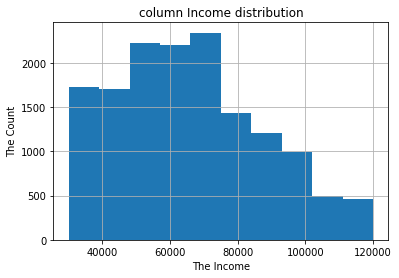

In [14]:
#view on the column income distribution
profile.income.hist()
plt.title("column Income distribution")
plt.xlabel("The Income")
plt.ylabel("The Count")

In [15]:
# gender distribution
profile.groupby('gender').id.count()

gender
F    6129
M    8484
O     212
Name: id, dtype: int64

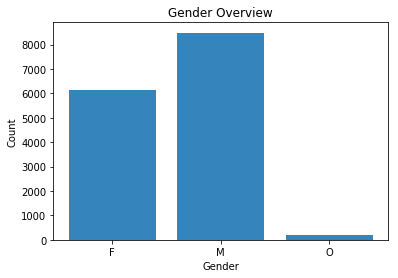

In [16]:
#view on the column gender distribution
Obj = ('F', 'M', 'O')
Y_position = np.arange(len(Obj))
per = list(profile.groupby('gender').id.count())
plt.bar(Y_position, per, align='center', alpha=0.9)
plt.xticks(Y_position, Obj)
plt.ylabel('Count')
plt.xlabel('Gender')
plt.title('Gender Overview')
plt.show()

Text(0,0.5,'The Count')

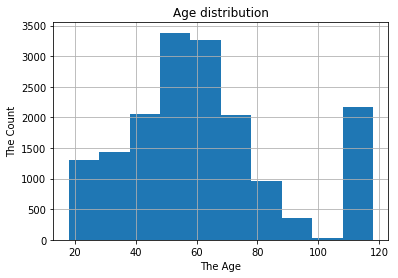

In [17]:
#view on the column Age distribution
profile.age.hist()
plt.title("Age distribution")
plt.xlabel("The Age")
plt.ylabel("The Count")

In [18]:
profile.isnull().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

After we shown the graphs we can except the missing value and it's encoded as 118 age which will be removed in the next following steps

In [19]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [20]:
 transcript.shape

(306534, 4)

In [21]:
#check for the null values
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

there are no null values

In [22]:
transcript.groupby('event').person.count()

event
offer completed     33579
offer received      76277
offer viewed        57725
transaction        138953
Name: person, dtype: int64

In [23]:
# the percentage on the event distribution
transcript.groupby('event').person.count()/transcript.shape[0] * 100.00

event
offer completed    10.954413
offer received     24.883700
offer viewed       18.831516
transaction        45.330371
Name: person, dtype: float64

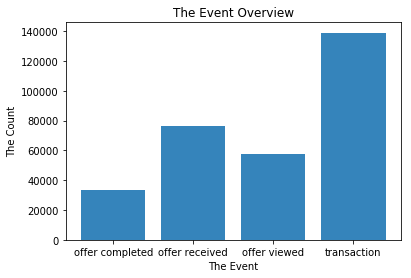

In [24]:
#view on the column Even distribution
Obj = ('offer completed', 'offer received', 'offer viewed', 'transaction')
Y_position = np.arange(len(Obj))
per = list(transcript.groupby('event').person.count())
plt.bar(Y_position, per, align='center', alpha=0.9)
plt.xticks(Y_position, Obj)
plt.ylabel('The Count')
plt.xlabel('The Event')
plt.title('The Event Overview')
plt.show()

In [25]:
transcript = pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,event,person,time,value,offer id,amount,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In [26]:
# clean the duplicates in offer id and offer_id and meger it  into one column
transcript['clean_id'] = np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(), transcript['offer_id'],transcript['offer id'])

In [27]:
# drop the original id columns
transcript.drop(['offer id', 'offer_id'], axis=1, inplace=True)

In [28]:
# rename the offer_id column
transcript.rename(columns={'clean_id': 'offer_id'}, inplace=True)

In [29]:
transcript.head()

,event,person,time,value,amount,reward,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [30]:
transcript.offer_id.nunique()

10

## Data Preprocessing

to find out what mainly affect the finish of the transaction by sending the offer , data reprocessing process need to process the data to meage the event of the specific offer .

In [31]:
# view on the event distribution by offer_type by combining(portfolio,transcript)
transcript=transcript.merge(portfolio,how='left',left_on='offer_id',right_on='id')
transcript.groupby(['event','offer_type'])['offer_type'].count()

event            offer_type   
offer completed  bogo             15669
                 discount         17910
offer received   bogo             30499
                 discount         30543
                 informational    15235
offer viewed     bogo             25449
                 discount         21445
                 informational    10831
Name: offer_type, dtype: int64

In [32]:
transcript_process = pd.DataFrame(transcript)
# drop the useless columns
transcript_process = transcript_process.drop(columns=['reward_x','reward_y'], axis=1,inplace=False)
transcript_process.head()

,event,person,time,value,amount,offer_id,channels,difficulty,duration,id,offer_type
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,2906b810c7d4411798c6938adc9daaa5,discount
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,fafdcd668e3743c1bb461111dcafc2a4,discount
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,5.0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo


In [33]:
# sort events by the person and time
transcript_process = transcript_process.sort_values(['person','time'])
transcript_process.head(10)

,event,person,time,value,amount,offer_id,channels,difficulty,duration,id,offer_type
55972,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational
89291,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN,NaN
113605,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational
153401,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5.0,5.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo
168412,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57},8.57,NaN,NaN,NaN,NaN,NaN,NaN
168413,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5.0,5.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5.0,5.0,f19421c1d4aa40978ebb69ca19b0e20d,bogo
204340,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,fafdcd668e3743c1bb461111dcafc2a4,discount


In [34]:
offer_complete = transcript_process[['time','offer_id','person','event']][(transcript_process['event']\
    =='transaction') | (transcript_process['event']=='offer viewed')].groupby(['person','offer_id']).ffill()
offer_complete['offer_id'] = offer_complete['offer_id'].ffill()
offer_complete.head()

,person,offer_id,time,event
77705,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,192,offer viewed
89291,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,228,transaction
139992,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,372,offer viewed
168412,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,414,transaction
187554,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,456,offer viewed


In [35]:
# create complete dataset to filtered the data
transcript_process = transcript_process.merge(offer_complete, how='left', on=['person','time','event'])
transcript_process.head()

,event,person,time,value,amount,offer_id_x,channels,difficulty,duration,id,offer_type,offer_id_y
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,3f207df678b143eea3cee63160fa8bed


In [36]:
# clean up dataframe 
transcript_process['offer_id'] = np.where(transcript_process['offer_id_x'].isnull(),\
                                            transcript_process['offer_id_y'], transcript_process['offer_id_x'])
transcript_process.drop(columns=['offer_id_x','offer_id_y'], axis=1, inplace=True)
transcript_process.head()

,event,person,time,value,amount,channels,difficulty,duration,id,offer_type,offer_id
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,"[email, mobile, social]",0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,5a8bc65990b245e5a138643cd4eb9837
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,"[email, mobile, social]",0.0,3.0,5a8bc65990b245e5a138643cd4eb9837,informational,5a8bc65990b245e5a138643cd4eb9837
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,NaN,NaN,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,"[web, email, mobile]",0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,3f207df678b143eea3cee63160fa8bed
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,"[web, email, mobile]",0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,3f207df678b143eea3cee63160fa8bed


In [37]:
transcript_process = transcript_process.merge(portfolio, how = 'left', left_on='offer_id', right_on='id')
transcript_process['duration'] = np.where(transcript_process['duration_x'].isnull(), \
                                            transcript_process['duration_y'], transcript_process['duration_x'])
transcript_process.drop(columns=['duration_x','offer_type_x','difficulty_x','channels_x','duration_y'],\
                         axis=1, inplace=True)
transcript_process.rename(columns={'channels_y':'channels','reward_y':'reward','difficulty_y':'difficulty','offer_type_y':'offer_type'},inplace=True)

#view processed dataset
transcript_process.head()

,event,person,time,value,amount,id_x,offer_id,channels,difficulty,id_y,offer_type,reward,duration
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0


In [38]:
# subset the dataset with only offer viewed 
transactions_view = transcript_process[(transcript_process['event']=='offer viewed')|\
                                                 (transcript_process['event']=='transaction')|\
                                                 (transcript_process['event']=='offer completed')].copy()

# generate offer id
transactions_view['pre_offer_id'] = transactions_view.groupby(['person', 'offer_id'])['offer_id'].shift()

# create flag for responsed offer 
transactions_view['completed_offer'] = np.where(transactions_view['pre_offer_id']==\
                                                       transactions_view['offer_id'],1,0)
transactions_view.head()

,event,person,time,value,amount,id_x,offer_id,channels,difficulty,id_y,offer_type,reward,duration,pre_offer_id,completed_offer
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,NaN,0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0,NaN,0
6,transaction,0009655768c64bdeb2e877511632db8f,414,{'amount': 8.57},8.57,NaN,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0,3f207df678b143eea3cee63160fa8bed,1
7,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,NaN,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5.0,NaN,0


In [39]:
# join the offer received events which was filter in the previous step
offer_receive = transcript_process[transcript_process['event']=='offer received']
offer_receive['pre_offer_id']=np.nan
offer_receive['completed_offer']=np.nan

transcript_process = offer_receive.append(transactions_view).sort_values(['person','time'])
transcript_process.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,event,person,time,value,amount,id_x,offer_id,channels,difficulty,id_y,offer_type,reward,duration,pre_offer_id,completed_offer
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,NaN,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0,NaN,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0,NaN,0.0


In [40]:
#split transcript into 3 different offer types
bogo = transcript_process[transcript_process['offer_type']=='bogo'].copy()
discount = transcript_process[transcript_process['offer_type']=='discount'].copy()
informational = transcript_process[transcript_process['offer_type']=='informational'].copy()

In [41]:
bogo.head()

,event,person,time,value,amount,id_x,offer_id,channels,difficulty,id_y,offer_type,reward,duration,pre_offer_id,completed_offer
5,offer received,0009655768c64bdeb2e877511632db8f,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5.0,NaN,NaN
7,offer completed,0009655768c64bdeb2e877511632db8f,414,{'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...,NaN,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5.0,NaN,0.0
8,offer viewed,0009655768c64bdeb2e877511632db8f,456,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5.0,f19421c1d4aa40978ebb69ca19b0e20d,1.0
10,transaction,0009655768c64bdeb2e877511632db8f,528,{'amount': 14.11},14.11,NaN,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5.0,f19421c1d4aa40978ebb69ca19b0e20d,1.0
20,offer received,00116118485d4dfda04fdbaba9a87b5c,168,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'},NaN,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,"[web, email, mobile, social]",5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,5.0,NaN,NaN


In [42]:
informational.head()

,event,person,time,value,amount,id_x,offer_id,channels,difficulty,id_y,offer_type,reward,duration,pre_offer_id,completed_offer
0,offer received,0009655768c64bdeb2e877511632db8f,168,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,NaN,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,192,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'},NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,228,{'amount': 22.16},22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,5a8bc65990b245e5a138643cd4eb9837,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0,NaN,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,372,{'offer id': '3f207df678b143eea3cee63160fa8bed'},NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0,NaN,0.0


In [43]:
discount.head()

,event,person,time,value,amount,id_x,offer_id,channels,difficulty,id_y,offer_type,reward,duration,pre_offer_id,completed_offer
9,offer received,0009655768c64bdeb2e877511632db8f,504,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,10.0,NaN,NaN
11,offer completed,0009655768c64bdeb2e877511632db8f,528,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,NaN,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,10.0,NaN,0.0
12,offer viewed,0009655768c64bdeb2e877511632db8f,540,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,10.0,fafdcd668e3743c1bb461111dcafc2a4,1.0
13,transaction,0009655768c64bdeb2e877511632db8f,552,{'amount': 13.56},13.56,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,10.0,fafdcd668e3743c1bb461111dcafc2a4,1.0
14,offer received,0009655768c64bdeb2e877511632db8f,576,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,2906b810c7d4411798c6938adc9daaa5,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10,2906b810c7d4411798c6938adc9daaa5,discount,2,7.0,NaN,NaN


 each one in offer type, use responded_offer flagged in previous steps, so we can filter out the offers which were successfully viewed, and completed by users. For BOGO and discount offer, the response offer should be the one with 'offer complete' events, and for the informational offer, just 'transaction' can be seen as a successful offer.

In [44]:
#extract responde offer
bogo_complete = bogo[['person','offer_id']][(bogo['completed_offer']==1) & (bogo['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()
discount_complete = discount[['person','offer_id']][(discount['completed_offer']==1) & (discount['event']=='offer completed')].groupby(['person','offer_id']).count().reset_index()


In [45]:
# filter out offer with transactions or complete
bogo_ID_transaction_complete = bogo[['person','offer_id']][(bogo['event']=='transaction') | \
                            (bogo['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()
bogo_ID_receive = bogo[['person','offer_id']][bogo['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()



In [46]:
# the offer records which was only viewe without transaction and completion
bogo_merge = bogo_ID_transaction_complete.merge(bogo_ID_receive,how='right',on=['person','offer_id'],indicator=True)
bogo_merge.head()

,person,offer_id,_merge
0,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,both
1,00116118485d4dfda04fdbaba9a87b5c,f19421c1d4aa40978ebb69ca19b0e20d,both
2,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,both
3,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,both
4,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,both


In [47]:
#same processing on discountrmational offer
discount_ID_transaction_complete = discount[['person','offer_id']][(discount['event']=='transaction') | \
                            (discount['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()
discount_ID_receive = discount[['person','offer_id']][discount['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()



In [48]:
#the offer records which was only viewe without transaction and completion
discount_merge = discount_ID_transaction_complete.merge(discount_ID_receive,how='right',on=['person','offer_id'],indicator=True)
discount_merge.head()

,person,offer_id,_merge
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,both
1,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,both
2,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,both
3,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,both
4,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,both


In [49]:
# subtract the customers who receive the offer without finished the transaction
bogo_no_transaction = bogo_merge[bogo_merge['_merge']=='right_only']
bogo_no_transaction = bogo_no_transaction.merge(transcript_process, how='left',on=['person','offer_id'])


In [50]:
# subset the users who only veiwed the offer 
# subset the people who viewe the offer but didn't make the transaction
bogo_view = bogo_no_transaction[['person','offer_id']][bogo_no_transaction['event']=='offer viewed']\
                .groupby(['person','offer_id']).count().reset_index()
bogo_no_transaction.drop(['_merge'], axis=1, inplace=True)

In [51]:
# get the customers who didn't even view the offer after they received the BOGO offer 
bogo_no_view = bogo_no_transaction.merge(bogo_view[['person','offer_id']], how='left', indicator=True)
bogo_no_view = bogo_no_view[bogo_no_view['_merge']=='left_only'].copy()

In [52]:
# subtract the customers who receive the offer without finish the transaction
discount_no_transaction = discount_merge[discount_merge['_merge']=='right_only']
discount_no_transaction = discount_no_transaction.merge(transcript_process, how='left',on=['person','offer_id'])


In [53]:
# subset the users who only veiw the offer and people who viewed the offer but didn't make transaction
discount_view = discount_no_transaction[['person','offer_id']][discount_no_transaction['event']=='offer viewed']\
                .groupby(['person','offer_id']).count().reset_index()
discount_no_transaction.drop(['_merge'], axis=1, inplace=True)

In [54]:
#the customers who didn't even view the offer after they receive the discount offer 
discount_no_view = discount_no_transaction.merge(discount_view[['person','offer_id']], how='left', indicator=True)
discount_no_view = discount_no_view[discount_no_view['_merge']=='left_only'].copy()

After the above process,the filter out the transaction regardless of receiving or viewing the offer.

In [55]:
# subset the offer which has no correction with offer
bogo_unrelate = bogo[['person','offer_id']][(bogo['event']=='offer completed') & (bogo['completed_offer']!=1)]\
                    .groupby(['person','offer_id']).count().reset_index()
discount_unrelate = discount[['person','offer_id']][(discount['event']=='offer completed')\
                    & (discount['completed_offer']!=1)].groupby(['person','offer_id']).count().reset_index()

In [56]:
# combine the 2 kind of customers cases which are focused on
bogo_complete['offer_responded']=1
bogo_view['offer_responded']=0
bogo_offer = bogo_complete.append(bogo_view, sort=False)
discount_complete['offer_responded']=1
discount_view['offer_responded']=0
discount_offer = discount_complete.append(discount_view, sort=False)

In [57]:
#convert time into days
informational['day_offer']=informational['time']/24


In [58]:
#drop unnecessary columns
informational.drop(['time','value','pre_offer_id'], axis=1, inplace=True)
informational=informational.sort_values(['person','day_offer','event','offer_id'])

In [59]:
#the difference in time for informational offers
informational['diff']=informational[(informational['offer_type']=='informational') \
                                         & ((informational['event']=='offer received')\
                                            | (informational['event']=='transaction'))].groupby(['person','offer_id'])['day_offer'].diff()
informational['valid_completion']=np.nan

In [60]:
#flag valid events if within duration
informational.loc[informational['diff']<=informational['duration'],'valid_completion']=1
#fill any missing values with 0 flag
informational['valid_completion']=informational['valid_completion'].fillna(value=0)
informational.head()

,event,person,amount,id_x,offer_id,channels,difficulty,id_y,offer_type,reward,duration,completed_offer,day_offer,diff,valid_completion
0,offer received,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,NaN,7.0,NaN,0.0
1,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,0.0,8.0,NaN,0.0
2,transaction,0009655768c64bdeb2e877511632db8f,22.16,NaN,5a8bc65990b245e5a138643cd4eb9837,"[email, mobile, social]",0,5a8bc65990b245e5a138643cd4eb9837,informational,0,3.0,1.0,9.5,2.5,1.0
3,offer received,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0,NaN,14.0,NaN,0.0
4,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,"[web, email, mobile]",0,3f207df678b143eea3cee63160fa8bed,informational,0,4.0,0.0,15.5,NaN,0.0


from the above table, only when customer make the transaction during the offer effective duration, it can be counted as successfully responsed offer

In [61]:
#flag successfully responded offer where completed_offer=1 and valid_completion=1
informational['offer_responded']=np.where(((informational['completed_offer']==1)\
                                           & (informational['valid_completion']==1)),1,0)

In [62]:
# extract the informational offer successfully compelted after
info_complete = informational[['person','offer_id']][informational['offer_responded']==1]\
                        .groupby(['person','offer_id']).sum().reset_index()

In [63]:
# filter out offer with transactions or completed, and offer which have viewed events
informational_ID_transaction_complete = informational[['person','offer_id']][(informational['event']=='transaction') | \
                            (informational['event']=='offer completed') ].groupby(['person','offer_id']).count().reset_index()
informational_ID_receive = informational[['person','offer_id']][informational['event']=='offer received'].groupby(['person','offer_id']).count().reset_index()

# get the offer records which was only viewed without transaction and completion
informational_merge = informational_ID_transaction_complete.merge(informational_ID_receive,how='right',on=['person','offer_id'],indicator=True)


In [64]:
informational_merge.head()

,person,offer_id,_merge
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,both
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,both
2,0011e0d4e6b944f998e987f904e8c1e5,3f207df678b143eea3cee63160fa8bed,both
3,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,both
4,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,both


In [65]:
# subtract the customers who received the offer without finishing the transaction
informational_no_transaction = informational_merge[informational_merge['_merge']=='right_only']
informational_no_transaction = informational_no_transaction.merge(transcript_process, how='left',on=['person','offer_id'])

# subset users who only veiwed the offer and people who viewed the offer but didn't make transaction
informational_view = informational_no_transaction[['person','offer_id']][informational_no_transaction['event']=='offer viewed']\
                .groupby(['person','offer_id']).count().reset_index()
informational_no_transaction.drop(['_merge'], axis=1, inplace=True)

# get the customers who didn't even view the offer after they received the informational offer 
informational_no_view = informational_no_transaction.merge(informational_view[['person','offer_id']], how='left', indicator=True)
informational_no_view = informational_no_view[informational_no_view['_merge']=='left_only'].copy()
#

In [66]:
# append the informational offer together
info_complete['offer_responded']=1
informational_view['offer_responded']=0
informational_offer = info_complete.append(informational_view, sort=False)

### Feature engineering
After basic processing, the next step will look if there are any columns that can be used to create new features.

In [67]:
profile.rename(columns={'id':'person'},inplace=True)

#create function to generate the length of time since the user become the member
def member_since(df):
    #merge to get user demographic profile
    df=df.merge(profile,how='left',on='person')
    df['year']=pd.Series([int(str(x)[:4]) for x in df['became_member_on']])
    df['month']=pd.Series([int(str(x)[-3]) for x in df['became_member_on']])
    df['day']=pd.Series([int(str(x)[-2:]) for x in df['became_member_on']])
    df = df.drop('became_member_on', axis=1, inplace=False)
    df.loc[df['year'] == 2018, 'membership_days'] = (30*df['month'])+df['day']
    df.loc[df['year'] != 2018, 'membership_days'] = ((2018-df['year'])*365)+(30*df['month'])+df['day']
    df = df.drop(['year','month','day'], axis=1, inplace=False)
    
    return df

bogo_offer=member_since(bogo_offer)
discount_offer=member_since(discount_offer)
informational_offer=member_since(informational_offer)
bogo_offer.head()

,person,offer_id,offer_responded,age,gender,income,membership_days
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,O,57000.0,39.0
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,F,90000.0,824.0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,F,60000.0,771.0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,F,60000.0,771.0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,F,74000.0,158.0


In [68]:
transcript.head()

,event,person,time,value,amount,reward_x,offer_id,channels,difficulty,duration,id,offer_type,reward_y
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,"[web, email, mobile]",5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,"[web, email]",20.0,10.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5.0
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},NaN,NaN,2906b810c7d4411798c6938adc9daaa5,"[web, email, mobile]",10.0,7.0,2906b810c7d4411798c6938adc9daaa5,discount,2.0
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,"[web, email, mobile, social]",10.0,10.0,fafdcd668e3743c1bb461111dcafc2a4,discount,2.0
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,"[web, email, mobile, social]",10.0,5.0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10.0


In [69]:
# generate the count of offers received per person
offer_count=transcript_process[transcript_process['event']=='offer received'].groupby(['person','offer_id','time']).count()['event'].reset_index()
offer_count.rename(columns={'event':'offer_received_cnt'},inplace=True)
offer_count.drop(['time'], axis=1, inplace=True)
# ensure only unique person-offer_id pairs
offer_count=offer_count.groupby(['person','offer_id']).sum().reset_index()

In [70]:
offer_count.head()

,person,offer_id,offer_received_cnt
0,0009655768c64bdeb2e877511632db8f,2906b810c7d4411798c6938adc9daaa5,1
1,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1
2,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1
3,0009655768c64bdeb2e877511632db8f,f19421c1d4aa40978ebb69ca19b0e20d,1
4,0009655768c64bdeb2e877511632db8f,fafdcd668e3743c1bb461111dcafc2a4,1


subtract the transactions which's not related to the offer

In [71]:
# subtract the transactions which's not related to the offer
transactions_not_relate=transcript_process[(transcript_process['event']=='transaction') & (transcript_process['completed_offer']==0)].groupby(['person','offer_id'])['amount'].sum().reset_index()
transactions_not_relate.rename(columns={'amount':'amount_invalid'},inplace=True)

calculate the time lap between offers

In [72]:
# convert time into days
transcript_process['day_offer']=transcript_process['time']/24

In [73]:
# drop unnecessary columns
transcript_process.drop(['time'], axis=1, inplace=True)

In [74]:
# calculate the time between offers
transcript_process['time_gap']=transcript_process[transcript_process['event']=='offer received'].groupby(['person','offer_id'])['day_offer'].diff()


In [75]:
# fill missing values with 0
transcript_process['time_gap']=transcript_process['time_gap'].fillna(value=0)
df_time_gap=transcript_process.groupby(['person','offer_id'])['time_gap'].sum().reset_index()


Merge the temporary data created above together, then drop the missing values in gender column, and split the channel column to the categorical variable

In [76]:
# merge to get offers received count and invalid amount transacted 
bogo_offer=bogo_offer.merge(offer_count[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
bogo_offer=bogo_offer.merge(transactions_not_relate[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])
# fill missing values for amount_invalid with 0
bogo_offer['amount_invalid']=bogo_offer['amount_invalid'].fillna(value=0)
bogo_offer.dropna(inplace=True)


In [77]:
bogo_offer.head()

,person,offer_id,offer_responded,age,gender,income,membership_days,offer_received_cnt,amount_invalid
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,O,57000.0,39.0,1,0.0
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,F,90000.0,824.0,1,0.0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,F,60000.0,771.0,1,0.0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,F,60000.0,771.0,1,0.0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,F,74000.0,158.0,1,0.0


In [78]:
# Split the channel column into categorical variables
def rename(col_name,df):
    df[col_name]=np.where(df[col_name]==col_name,1,0)
    return df
# dummy variable encoding function
def dummy(df,col):
    df = pd.concat([df[:],pd.get_dummies(df[col],prefix=col)],axis=1)
    df = df.drop([col], axis=1, inplace=False)
    return df
portfolio.rename(columns={'id':'offer_id'}, inplace=True)

In [79]:
# merge with portfolio to get offer details
bogo_offer=bogo_offer.merge(portfolio,how='left',on='offer_id')
# convert channels into categorical variables
channels = bogo_offer['channels'].apply(pd.Series)
channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})
bogo_offer = pd.concat([bogo_offer[:], channels[:]], axis=1)
rename('web',bogo_offer)
rename('email',bogo_offer)
rename('mobile',bogo_offer)
rename('social',bogo_offer)
bogo_offer = bogo_offer.drop(['channels'], axis=1, inplace=False)
# convert gender into categorical variables
bogo_offer=dummy(bogo_offer,'gender')

In [80]:
bogo_offer.head()

,person,offer_id,offer_responded,age,income,membership_days,offer_received_cnt,amount_invalid,difficulty,duration,offer_type,reward,web,email,mobile,social,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,40,57000.0,39.0,1,0.0,5,7,bogo,5,1,1,1,0,0,0,1
1,0020c2b971eb4e9188eac86d93036a77,4d5c57ea9a6940dd891ad53e9dbe8da0,1,59,90000.0,824.0,1,0.0,10,5,bogo,10,1,1,1,1,1,0,0
2,0020ccbbb6d84e358d3414a3ff76cffd,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,24,60000.0,771.0,1,0.0,5,7,bogo,5,1,1,1,0,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,f19421c1d4aa40978ebb69ca19b0e20d,1,24,60000.0,771.0,1,0.0,5,5,bogo,5,1,1,1,1,1,0,0
4,004b041fbfe44859945daa2c7f79ee64,f19421c1d4aa40978ebb69ca19b0e20d,1,55,74000.0,158.0,1,0.0,5,5,bogo,5,1,1,1,1,1,0,0


In [81]:
discount_offer.head()

,person,offer_id,offer_responded,age,gender,income,membership_days
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,40,O,57000.0,39.0
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,40,O,57000.0,39.0
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1,59,F,90000.0,824.0
3,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1,24,F,60000.0,771.0
4,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,1,26,F,73000.0,566.0


In [82]:
# do the same processing on discount data
# merge to get offers received count and invalid amount transacted 
discount_offer = discount_offer.merge(offer_count[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
discount_offer = discount_offer.merge(transactions_not_relate[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])
# fill missing values for amount_invalid with 0
discount_offer['amount_invalid']=discount_offer['amount_invalid'].fillna(value=0)
discount_offer.dropna(inplace=True)

In [83]:
# merge with portfolio to get offer details
discount_offer= discount_offer.merge(portfolio,how='left',on='offer_id')
# convert channels into categorical variables
channels = discount_offer['channels'].apply(pd.Series)
channels = channels.rename(columns={0:'web',1:'email',2:'mobile',3:'social'})
discount_offer = pd.concat([discount_offer[:], channels[:]], axis=1)
rename('web',discount_offer)
rename('email',discount_offer)
rename('mobile',discount_offer)
rename('social',discount_offer)
discount_offer = discount_offer.drop(['channels'], axis=1, inplace=False)
#convert gender into categorical variables
discount_offer=dummy(discount_offer,'gender')

In [84]:
discount_offer.head()

,person,offer_id,offer_responded,age,income,membership_days,offer_received_cnt,amount_invalid,difficulty,duration,offer_type,reward,web,email,mobile,social,gender_F,gender_M,gender_O
0,0011e0d4e6b944f998e987f904e8c1e5,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,40,57000.0,39.0,1,0.0,20,10,discount,5,1,1,0,0,0,0,1
1,0011e0d4e6b944f998e987f904e8c1e5,2298d6c36e964ae4a3e7e9706d1fb8c2,1,40,57000.0,39.0,1,0.0,7,7,discount,3,1,1,1,1,0,0,1
2,0020c2b971eb4e9188eac86d93036a77,fafdcd668e3743c1bb461111dcafc2a4,1,59,90000.0,824.0,2,0.0,10,10,discount,2,1,1,1,1,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,2298d6c36e964ae4a3e7e9706d1fb8c2,1,24,60000.0,771.0,1,0.0,7,7,discount,3,1,1,1,1,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,fafdcd668e3743c1bb461111dcafc2a4,1,26,73000.0,566.0,2,0.0,10,10,discount,2,1,1,1,1,1,0,0


In [85]:
# processing on informational data
# merge with portfolio to get offer details
informational_offer = informational_offer.merge(portfolio,how='left',on='offer_id')
# reset index for informational_offer
informational_offer = informational_offer.reset_index().drop(['index'],axis=1,inplace=False)
# split the channel column
informational_offer['email']= np.nan
informational_offer.loc[pd.Series(['email' in informational_offer['channels'][x] for x in range(len(informational_offer['channels']))]),'email']=1
informational_offer['email']=informational_offer['email'].fillna(value=0)

informational_offer['mobile']= np.nan
informational_offer.loc[pd.Series(['mobile' in informational_offer['channels'][x] for x in range(len(informational_offer['channels']))]),'mobile']=1
informational_offer['mobile']=informational_offer['mobile'].fillna(value=0)

informational_offer['social']= np.nan
informational_offer.loc[pd.Series(['social' in informational_offer['channels'][x] for x in range(len(informational_offer['channels']))]),'social']=1
informational_offer['social']=informational_offer['social'].fillna(value=0)

# drop the useless columns
informational_offer.drop(['channels'], axis=1, inplace=True)

In [86]:
# merge the informational offer dataframe
informational_offer = informational_offer.merge(offer_count[['person','offer_id','offer_received_cnt']],how='left',on=['person','offer_id'])
informational_offer = informational_offer.merge(transactions_not_relate[['person','offer_id','amount_invalid']],how='left',on=['person','offer_id'])
# fill missing values for amount_invalid and offer_received_cnt with 0
informational_offer['amount_invalid']=informational_offer['amount_invalid'].fillna(value=0)
#drop income and gender null rows
informational_offer.dropna(inplace=True);    
#convert gender column into dummy variables
informational_offer=dummy(informational_offer,'gender')

In [87]:
informational_offer.head()

,person,offer_id,offer_responded,age,income,membership_days,difficulty,duration,offer_type,reward,email,mobile,social,offer_received_cnt,amount_invalid,gender_F,gender_M,gender_O
0,0009655768c64bdeb2e877511632db8f,3f207df678b143eea3cee63160fa8bed,1,33,72000.0,506.0,0,4,informational,0,1.0,1.0,0.0,1.0,0.00,0,1,0
1,0009655768c64bdeb2e877511632db8f,5a8bc65990b245e5a138643cd4eb9837,1,33,72000.0,506.0,0,3,informational,0,1.0,1.0,1.0,1.0,0.00,0,1,0
2,0020c2b971eb4e9188eac86d93036a77,5a8bc65990b245e5a138643cd4eb9837,1,59,90000.0,824.0,0,3,informational,0,1.0,1.0,1.0,1.0,0.00,1,0,0
3,0020ccbbb6d84e358d3414a3ff76cffd,5a8bc65990b245e5a138643cd4eb9837,1,24,60000.0,771.0,0,3,informational,0,1.0,1.0,1.0,1.0,16.27,1,0,0
4,003d66b6608740288d6cc97a6903f4f0,3f207df678b143eea3cee63160fa8bed,1,26,73000.0,566.0,0,4,informational,0,1.0,1.0,0.0,1.0,0.00,1,0,0


### Buliding model

After we pre-processing the data,so the next step is start to implement models to figure out which factors affect most whether the customer will respond to the offer or not. And this project also attempts to predict whether the customer will respond to the different types of offers or not.

we'll use the 'offer_responded' flag in the dataset to build the models to predict if the customer will respond to the offer. so we will choose the basic tree model as a baseline which will help us to explain the feature importance better so that we can get some insight into whatthe factors affect customer's behavior most. 
I will also choose a random forest as an alternate model to compare the baseline model is as an improvement over simple ensemble bagging of decision trees, in order to drive towards a high accuracy in training the model.
 
 ### Model implementation preparation
 prepare the dataset

In [88]:
def data_prep(df,drop_cols_prep):
    # Split the data into features and target label
    target = df['offer_responded']
    features = df.drop(drop_cols_prep, axis=1, inplace=False)
    return features,target

In [89]:
# split the data 
def model_pipeline(features,target):    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features,target, test_size=0.20, random_state=42)

    #fit and transform scaling on training data
    scaler=StandardScaler()
    X_train=scaler.fit_transform(X_train)

    #scale test data
    X_test=scaler.transform(X_test)
    return X_train,X_test,y_train, y_test

In [90]:
def train_predict(model, X_train, y_train, X_test, y_test): 
    results = {}

    #Fit the model to the training data and get training time
    start = time() 
    model = model.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set
    start = time() 
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    end = time() 
    
    # Calculate the prediction time
    results['pred_time'] = end-start
    #add training accuracy to results
    results['training_score']=model.score(X_train,y_train)
    #add testing accuracy to results
    results['testing_score']=model.score(X_test,y_test)
     
    print("{} trained on {} samples.".format(model.__class__.__name__, len(y_train)))
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    return results

In [91]:
def run_model(clf1,clf2,name):    
    # Collect results from models
    results = {}
    for clf in [clf1, clf2]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

### Performance Metrics
 the project is building a classification model, I choose both accuracy and F1 score as the model evaluation metric. The reason why I choose both metrics is sometimes when the dataset is imbalanced, the accuracy only couldn't objectively show how the model is performing on the dataset, while the F1 score provides a better sense of model performance compared to pure accuracy as takes both false positives and false negatives in the calculation. With an imbalanced class distribution, F1 may be more useful than accuracy.

so, since the F1 score is based on the harmonic mean of precision and recall, and focuses on positive cases. For the Starbucks app here, it would be fine as we would prioritize more on whether offers are effective, and less focus on why offers are ineffective.

#### Initial the model baseline
so, we will use default parameters for the baseline model and then we will tune the parameters in the later tuning steps if needed.

#### Baseline of model
- Calculate the conversion rate of each type of offer as the benchmark used for comparison with the final model

In [92]:
# subset the dataset with only offer received, viewed
receive_view = transcript_process[(transcript_process['event']=='offer received')|\
                                                 (transcript_process['event']=='offer viewed')].copy()
# generate the previous offer id
receive_view['pre_offer_id'] = receive_view.groupby(['person', 'offer_id'])['offer_id'].shift()
receive_view.loc[:,('event','person','amount','offer_id','pre_offer_id')].head()

,event,person,amount,offer_id,pre_offer_id
0,offer received,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
1,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837
3,offer received,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,NaN
4,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed
5,offer received,0009655768c64bdeb2e877511632db8f,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN


In [93]:
# only use offer which viewed after received 
view_after_receive = receive_view[(receive_view['event']=='offer received') \
                                                  & (receive_view['pre_offer_id'].isnull())]
count_view_after_receive = view_after_receive.event.count()
count_view_after_receive

63288

In [94]:
# count of offer view after receive by type of offer
count_view_after_receive_group = view_after_receive.groupby('offer_type').event.count()
count_view_after_receive_group

offer_type
bogo             25321
discount         25316
informational    12651
Name: event, dtype: int64

In [95]:
# subset the dataset with only offer viewed and completed
view_complete = transcript_process[(transcript_process['event']=='offer viewed')|\
                                        (transcript_process['event']=='offer completed')|\
                                        (transcript_process['event']=='transaction')].copy()

# generate the previous offer id
view_complete['pre_offer_id'] = view_complete.groupby(['person', 'offer_id'])['offer_id'].shift()
view_complete['pre_day_offer'] = view_complete.groupby(['person', 'offer_id'])['day_offer'].shift()
view_complete['info_offer_time']=view_complete['day_offer']-view_complete['pre_day_offer']
view_complete.loc[:,('event','person','amount','day_offer','offer_id','pre_offer_id','pre_day_offer',\
                        'info_offer_time','offer_type')].head(15)

,event,person,amount,day_offer,offer_id,pre_offer_id,pre_day_offer,info_offer_time,offer_type
1,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,8.00,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN,NaN,informational
2,transaction,0009655768c64bdeb2e877511632db8f,22.16,9.50,5a8bc65990b245e5a138643cd4eb9837,5a8bc65990b245e5a138643cd4eb9837,8.00,1.50,informational
4,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,15.50,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN,informational
6,transaction,0009655768c64bdeb2e877511632db8f,8.57,17.25,3f207df678b143eea3cee63160fa8bed,3f207df678b143eea3cee63160fa8bed,15.50,1.75,informational
7,offer completed,0009655768c64bdeb2e877511632db8f,NaN,17.25,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN,bogo
8,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,19.00,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,17.25,1.75,bogo
10,transaction,0009655768c64bdeb2e877511632db8f,14.11,22.00,f19421c1d4aa40978ebb69ca19b0e20d,f19421c1d4aa40978ebb69ca19b0e20d,19.00,3.00,bogo
11,offer completed,0009655768c64bdeb2e877511632db8f,NaN,22.00,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN,discount
12,offer viewed,0009655768c64bdeb2e877511632db8f,NaN,22.50,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,22.00,0.50,discount
13,transaction,0009655768c64bdeb2e877511632db8f,13.56,23.00,fafdcd668e3743c1bb461111dcafc2a4,fafdcd668e3743c1bb461111dcafc2a4,22.50,0.50,discount


In [96]:
# only use offer which completed after reviewed
complete_after_view = view_complete[((view_complete['event']=='offer completed') \
                                                     & (view_complete['pre_offer_id'].notnull()))\
                                         |((view_complete['event']=='transaction')\
                                           &(view_complete['offer_type']=='informational')\
                                          &(view_complete['pre_offer_id'].notnull())\
                                          &(view_complete['info_offer_time']<1))]
count_completed_after_view = complete_after_view.event.count()
count_completed_after_view

32986

In [97]:
# count of offer completed after viewed by type of offer
count_completed_after_view_group = complete_after_view.groupby('offer_type').event.count()
count_completed_after_view_group

offer_type
bogo             12054
discount         13601
informational     7331
Name: event, dtype: int64

In [98]:
# overall current conversion rate
conversion_overall = count_completed_after_view/count_view_after_receive * 100.00
conversion_overall

52.120465175072681

In [99]:
conversion_group = count_completed_after_view/count_view_after_receive_group * 100.00
conversion_group

offer_type
bogo             130.271316
discount         130.297045
informational    260.738282
Name: event, dtype: float64

In [100]:
# implement the model for BOGO offer
drop_cols_prep=['person','offer_id','offer_responded','offer_type']
features,target=data_prep(bogo_offer,drop_cols_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

# initialize the model - baseline is DT model, bogo_1 model is RF model
baseline = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)
bogo_a = RandomForestClassifier(random_state=2,max_depth= 11, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=20)

results=run_model(baseline,bogo_a,'bogo_1')

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1770
MSE_test: 0.1823
Training accuracy:0.8230
Test accuracy:0.8177
             precision    recall  f1-score   support

          0     0.4797    0.2694    0.3450       438
          1     0.8553    0.9366    0.8941      2020

avg / total     0.7884    0.8177    0.7963      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1670
MSE_test: 0.1786
Training accuracy:0.8330
Test accuracy:0.8214
             precision    recall  f1-score   support

          0     0.4906    0.0594    0.1059       438
          1     0.8287    0.9866    0.9008      2020

avg / total     0.7684    0.8214    0.7591      2458



so, the accuracy of both models is good (more than 80%) for initial model implementation.
But the F1 score is a bit lower than accuracy which may be tuned better in the later steps. From the result, we can see that Decision Tree's F1 performs a little better than Random Forest, which means that the decision tree is doing slightly better compared to the random forest at not misclassifying negative events as positive (meaning, misclassifying people on which offers are ineffective, as people on which offers would be effective).

But the overall higher accuracy compared to the F1 score indicates that the model is predicting the positive case (i.e. where an offer is responded to) more accurately compared to predicting the negative cases (i.e. where an offer is not responded to), which is expected given the uneven classes.

However, in this project context, there's not big hurt to send out some more offers to people who are not gonna respond in the end. Therefore, here can still select the random forest with slightly better accuracy right now. So, right now, will stay on the random forest model.

In [101]:
# instantiate the model for discount offer
drop_columns_prep=['person','offer_id','offer_responded','offer_type']
features,target=data_prep(discount_offer,drop_columns_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
discount_a = RandomForestClassifier(random_state=2,max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)
results=pd.concat([results[:],run_model(baseline,discount_a,'discount_1')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1313
MSE_test: 0.1277
Training accuracy:0.8687
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.5000    0.0062    0.0122       325
          1     0.8729    0.9991    0.9317      2220

avg / total     0.8253    0.8723    0.8143      2545



so, the random forest performs quite similarly to the random forest, but the decision tree got a slightly lower F1 score. The F1 score for these models is lower overall compared to the Accuracy score.

As mentioned in previous steps, it's more important in this business case for the model predicting positive cases accurately, so would rather go with a higher accuracy model where the F1 score is higher, for which random forest classifier has better performance (0.814 vs 0.812).

In [102]:
# implement model for informational offer
features,target=data_prep(informational_offer,drop_columns_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#Initialize the model
info_1 = RandomForestClassifier(random_state=5,criterion='gini',max_depth= 20, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)
results=pd.concat([results[:],run_model(baseline,info_1,'info_1')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2319
MSE_test: 0.2520
Training accuracy:0.7681
Test accuracy:0.7480
             precision    recall  f1-score   support

          0     0.5200    0.1099    0.1814       355
          1     0.7610    0.9655    0.8511      1042

avg / total     0.6997    0.7480    0.6809      1397



### Model tunning

in this section i will attempt to tune the parameters of the initial model by using the GridSearch method to get the higher performance.

In [103]:
# create the function to find the best model results for each of offer type
def best_model(offer_type):
    print(offer_type + ' RF model:')
    return results.transpose()[results.transpose()['testing_score']==results.transpose()[results.transpose().index.str.contains("RandomForestClassifier_"+offer_type)]['testing_score'].max()]


In [104]:
#define Grid Search function
def rand_forest_param_selection(X,y):
    param_grid={'max_features': ['auto', 'sqrt'],
                'max_depth' : [10,15],
                'n_estimators': [10,20,25,30],
                'min_samples_split': [10, 20],
                'min_samples_leaf': [10,15],
                }
    grid_search = GridSearchCV(RandomForestClassifier(random_state=2), param_grid)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

In [105]:
#define BOGO dataset
features,target=data_prep(bogo_offer,drop_columns_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)
#run Grid Search
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 20}

In [106]:
# use optimized parameters to rerun the model in previous step
# initialize the model
bogo_b = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=10)

results=pd.concat([results[:],run_model(baseline,bogo_b,'bogo_2')],axis=1)

DecisionTreeClassifier trained on 9829 samples.
MSE_train: 0.1770
MSE_test: 0.1823
Training accuracy:0.8230
Test accuracy:0.8177
             precision    recall  f1-score   support

          0     0.4797    0.2694    0.3450       438
          1     0.8553    0.9366    0.8941      2020

avg / total     0.7884    0.8177    0.7963      2458

RandomForestClassifier trained on 9829 samples.
MSE_train: 0.1613
MSE_test: 0.1717
Training accuracy:0.8387
Test accuracy:0.8283
             precision    recall  f1-score   support

          0     0.5870    0.1233    0.2038       438
          1     0.8377    0.9812    0.9038      2020

avg / total     0.7930    0.8283    0.7790      2458



In [107]:
# compare tuned model to initial one
results[['RandomForestClassifier_bogo_1','RandomForestClassifier_bogo_2']]

,RandomForestClassifier_bogo_1,RandomForestClassifier_bogo_2
pred_time,0.030527,0.030778
testing_score,0.821400,0.828316
train_time,0.132049,0.134073
training_score,0.833045,0.838742


In [108]:
# compare the tuned model to decision tree model
results[['DecisionTreeClassifier_bogo_1','RandomForestClassifier_bogo_2']]

,DecisionTreeClassifier_bogo_1,RandomForestClassifier_bogo_2
pred_time,0.001549,0.030778
testing_score,0.817738,0.828316
train_time,0.023198,0.134073
training_score,0.822973,0.838742


In [109]:
# the best model for BOGO offer type
best_model('bogo')

bogo RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_bogo_2,0.030778,0.828316,0.134073,0.838742


As shown above in the comparison, after we using the tune parameters, the test accuracy 

In [110]:
# do the same tuning and refit steps on discount offer
features,target=data_prep(discount_offer,drop_columns_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

# run Grid Search
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 15,
 'min_samples_split': 10,
 'n_estimators': 30}

In [111]:
# initialize the model
discount_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 10,n_estimators=30,min_samples_leaf=15)
results=pd.concat([results[:],run_model(baseline,discount_2,'discount_2')],axis=1)

DecisionTreeClassifier trained on 10179 samples.
MSE_train: 0.1371
MSE_test: 0.1277
Training accuracy:0.8629
Test accuracy:0.8723
             precision    recall  f1-score   support

          0     0.0000    0.0000    0.0000       325
          1     0.8723    1.0000    0.9318      2220

avg / total     0.7609    0.8723    0.8128      2545



/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


RandomForestClassifier trained on 10179 samples.
MSE_train: 0.1350
MSE_test: 0.1261
Training accuracy:0.8650
Test accuracy:0.8739
             precision    recall  f1-score   support

          0     1.0000    0.0123    0.0243       325
          1     0.8737    1.0000    0.9326      2220

avg / total     0.8898    0.8739    0.8166      2545



In [112]:
# compare between the tuned model to initial one
results[['RandomForestClassifier_discount_1','RandomForestClassifier_discount_2']]

,RandomForestClassifier_discount_1,RandomForestClassifier_discount_2
pred_time,0.037835,0.055886
testing_score,0.872299,0.873870
train_time,0.160891,0.197875
training_score,0.868749,0.865016


In [114]:
# the best model for discount offer type
best_model('discount')

discount RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_discount_2,0.055886,0.87387,0.197875,0.865016


In [113]:
# compare between the tuned model to decision tree model
results[['DecisionTreeClassifier_discount_1','RandomForestClassifier_bogo_2']]

,DecisionTreeClassifier_discount_1,RandomForestClassifier_bogo_2
pred_time,0.001494,0.030778
testing_score,0.872299,0.828316
train_time,0.020458,0.134073
training_score,0.862855,0.838742


As shown above in the comparison, after using tune parameters, the test accuracy slightly improved

In [115]:
# model tuning for informational offer model
features,target=data_prep(informational_offer,drop_columns_prep)
X_train, X_test, y_train, y_test=model_pipeline(features,target)

#run Grid Search
rand_forest_param_selection(X_train, y_train)

{'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 10,
 'min_samples_split': 10,
 'n_estimators': 10}

In [116]:
# rerun the model with selected paramenters
info_2 = RandomForestClassifier(random_state=2,max_depth= 10, max_features= 'auto',min_samples_split= 10,n_estimators=10,min_samples_leaf=10)
results=pd.concat([results[:],run_model(baseline,info_2,'info_2')],axis=1)

DecisionTreeClassifier trained on 5585 samples.
MSE_train: 0.2462
MSE_test: 0.2541
Training accuracy:0.7538
Test accuracy:0.7459
             precision    recall  f1-score   support

          0     0.5000    0.1127    0.1839       355
          1     0.7608    0.9616    0.8495      1042

avg / total     0.6945    0.7459    0.6804      1397

RandomForestClassifier trained on 5585 samples.
MSE_train: 0.2378
MSE_test: 0.2470
Training accuracy:0.7622
Test accuracy:0.7530
             precision    recall  f1-score   support

          0     0.5893    0.0930    0.1606       355
          1     0.7599    0.9779    0.8552      1042

avg / total     0.7165    0.7530    0.6787      1397



In [118]:
# compare between the tuned model to decision tree model
results[['DecisionTreeClassifier_info_1','RandomForestClassifier_bogo_2']]

,DecisionTreeClassifier_info_1,RandomForestClassifier_bogo_2
pred_time,0.000784,0.030778
testing_score,0.745884,0.828316
train_time,0.010551,0.134073
training_score,0.753805,0.838742


In [117]:
# compare between the tuned model to initial one
results[['RandomForestClassifier_info_1','RandomForestClassifier_info_2']]

,RandomForestClassifier_info_1,RandomForestClassifier_info_2
pred_time,0.019967,0.008903
testing_score,0.748031,0.753042
train_time,0.090628,0.040970
training_score,0.768129,0.762220


In [119]:
# best model for informational offer type
best_model('info')

info RF model:


,pred_time,testing_score,train_time,training_score
RandomForestClassifier_info_2,0.008903,0.753042,0.04097,0.76222


As shown above in the comparison, after using tune parameters, the test accuray slightly improved 

### View the feature importance
so now we will look at the model result and see if there's any insight of main factors which decide whether customers will respond to the offers we could get by investigating feature importance.

In [120]:
# models summary
best_model('bogo').append([best_model('discount'),best_model('info')]).transpose()

bogo RF model:
discount RF model:
info RF model:


,RandomForestClassifier_bogo_2,RandomForestClassifier_discount_2,RandomForestClassifier_info_2
pred_time,0.030778,0.055886,0.008903
testing_score,0.828316,0.873870,0.753042
train_time,0.134073,0.197875,0.040970
training_score,0.838742,0.865016,0.762220


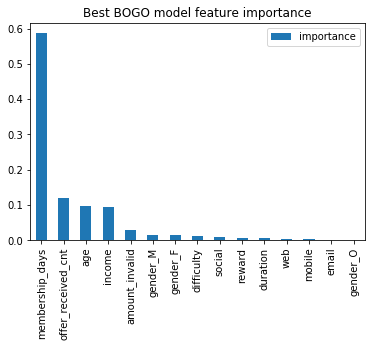

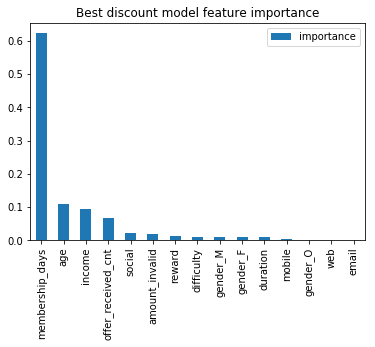

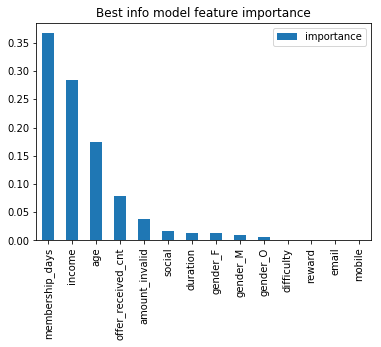

In [121]:
drop_columns_prep=['person','offer_id','offer_responded','offer_type']
features,target=data_prep(bogo_offer,drop_columns_prep)

feature_importances = pd.DataFrame(bogo_b.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best BOGO model feature importance')
plt.show()

#discount model
feature_importances = pd.DataFrame(discount_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best discount model feature importance')
plt.show()

#informational model
drop_cols_prep=['person','offer_id','offer_responded','offer_type']
features,target=data_prep(informational_offer,drop_cols_prep)
#print feature importance
feature_importances = pd.DataFrame(info_2.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
feature_importances.plot.bar()
plt.title('Best info model feature importance')
plt.show()

we can see in our figure that  for all of the three types of offer, the most important factor that affects the offer largely and will be responded to eventually is the length of membership. so  the longer customer is a member of Starbucks, the more likely he will respond to the offer they receive. Then the second and third of the important factors which affect the possibility of customer's response are income and age which make it sense and the number of the offers they received will also affect the response a lot.

# Conclusion 
in this project we try to figure out :
how possible will the customers open and used the offer that sends to them? what are the common characteristics of the customers who take the offer?
what is the main effect of the usage of the offer? should the company send out the offer for them or not?

From the result of the project, it's likely to use machine learning model to predict whether the customer will respond to the offer or not, and the model also shows that the main important factors that affect the usage such as the length of membership, age, income which highly affect the possibility of customer's responding to the offer.